In [2]:
import numpy as np  
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2

from google.colab import drive

import sys
import pickle
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import *
#from keras.objectives import *
from keras.metrics import binary_accuracy
from keras.models import load_model
import keras.backend as K
from keras.preprocessing.image import *
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score
from keras import optimizers
import time




drive.mount('/content/drive',force_remount=True)
# adding Segmentation to the system path
sys.path.insert(0, '/content/drive/MyDrive/CV_project_HGR')
sys.path.insert(0, '/content/drive/MyDrive/CV_project_HGR/Segmentation')
from Full_Model_modify import FullModel
from Seg_model_modify import SegModel

Mounted at /content/drive


In [3]:
#########
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, Conv2D, Input,AveragePooling2D,UpSampling2D
from keras.models import Model
#########

In [4]:
#######################
### Load Train data ###
#######################
train_root = "/content/drive/MyDrive/CV_project_HGR/datasets/train" 

train_image_path = os.path.join(train_root,"train_color")
train_target_image_path = os.path.join(train_root,"train_segmentation")

train_image_path_list = []
train_target_image_path_list = []

for filepath in os.listdir(train_image_path):
    train_image_path_list.append(os.path.join(train_image_path, filepath))
for filepath in os.listdir(train_target_image_path):
    train_target_image_path_list.append(os.path.join(train_target_image_path, filepath))

trainX = []
trainY = []

img_dim = (480, 480)

train_image_path_list = sorted(train_image_path_list)
m = len(train_image_path_list)
for i in range(len(train_image_path_list)):
    img = Image.open(str(train_image_path_list[i]))
    arr = np.array(img.resize(img_dim))
    trainX.append(arr)

train_target_image_path_list = sorted(train_target_image_path_list)
m = len(train_target_image_path_list)
for j in range(len(train_target_image_path_list)):
    img = Image.open(str(train_target_image_path_list[j]))
    arr = np.array(img.resize(img_dim))
    trainY.append(arr)

## Train data
# train input
trainImages = np.array(trainX)
trainImages = trainImages.astype('float32')
trainImages /= 255.0
# train target
trainMasks = np.array(trainY)
trainMasks[trainMasks > 0] = 255
trainMasks[trainMasks <= 0] = 0
trainMasks = trainMasks.astype('float32')
trainMasks /= 255.0


In [5]:
print(trainImages.shape)
print(trainMasks.shape)

(2000, 480, 480, 3)
(2000, 480, 480)


In [5]:
####################
### Segmentation ###
####################
## Parameter setting
batch_size = 2
epochs = 200
learningRate = 0.001
ch = 3

## Fscore evaluation 
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0

    m, height, weight = Masks.shape
    _Masks = np.zeros([m, height, weight, 1])
    for i in range(len(Images)):
        total += 1

        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        _Masks[i] = Masks[i].reshape((len(Masks[i][0]), len(Masks[i][1]), 1))
        label = img_to_array(np.squeeze(_Masks[i], axis=2)).astype(int)
        #pred = tp[i]
        #label = Masks[i]
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

#### Compile segmentation model ####
input_size = (img_dim[0], img_dim[1], ch)
SegM_modify = SegModel(input_size)
model = SegM_modify.model
adam_optimizer = optimizers.Adam(learning_rate=learningRate, beta_1=0.9, beta_2=0.999, decay=0.0)
model.compile(loss='binary_crossentropy',optimizer = adam_optimizer,metrics=['accuracy'])
checkpoint_filepath = '/content/drive/MyDrive/Programming/CV_project_HGR/checkpoint/checkfile_modify'
model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc',verbose=1, save_weights_only=True)

## train data
start = time.time()
hist = model.fit(trainImages, trainMasks, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=[model_checkpoint])
print(time.time()-start)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 480, 480, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 480, 480, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [6]:
#######################
### Load Test data ###
#######################
test_root = "/content/drive/MyDrive/CV_project_HGR/datasets/test"

test_image_path = os.path.join(test_root,"test_color")
test_target_image_path = os.path.join(test_root,"test_segmentation")

test_image_path_list = []
test_target_image_path_list = []

for filepath in os.listdir(test_image_path):
    test_image_path_list.append(os.path.join(test_image_path, filepath))
for filepath in os.listdir(test_target_image_path):
    test_target_image_path_list.append(os.path.join(test_target_image_path, filepath))

testX = []
testY = []
img_dim = (480, 480)

test_image_path_list = sorted(test_image_path_list)
for i in range(len(test_image_path_list)):
    img = Image.open(str(test_image_path_list[i]))
    arr = np.array(img.resize(img_dim))
    testX.append(arr)

test_target_image_path_list = sorted(test_target_image_path_list)
for j in range(len(test_target_image_path_list)):
    img = Image.open(str(test_target_image_path_list[j]))
    arr = np.array(img.resize(img_dim))
    testY.append(arr)

## Test data
# test input
testImages = np.array(testX)
testImages = testImages.astype('float32')
testImages /= 255.0
# test target
testMasks = np.array(testY)
testMasks[testMasks > 0] = 255
testMasks[testMasks <= 0] = 0
testMasks = testMasks.astype('float32')
testMasks /= 255.0

In [7]:
print(testImages.shape)
print(testMasks.shape)

(1000, 480, 480, 3)
(1000, 480, 480)


In [8]:
#### Predict Segmentation data ####
from tensorflow.keras.utils import img_to_array

y_pred = model.predict(testImages)
f = fscore(y_pred, testImages, testMasks)
print(f"hist information: {hist.history}")
print(f"fscore = {f}")

32/32 [==============================] - 6s 128ms/step
hist information: {'loss': [0.08044115453958511, 0.04799112305045128, 0.04126235470175743, 0.03749088943004608, 0.03712107986211777, 0.03390805795788765, 0.03548401966691017, 0.032211560755968094, 0.03268104046583176, 0.030660554766654968, 0.029950222000479698, 0.029175158590078354, 0.029562925919890404, 0.02867465652525425, 0.02832876145839691, 0.027845723554491997, 0.027202878147363663, 0.028100162744522095, 0.02678799070417881, 0.02627839893102646, 0.028201479464769363, 0.025883503258228302, 0.025661993771791458, 0.02562551014125347, 0.025415977463126183, 0.024876821786165237, 0.02487020194530487, 0.024554427713155746, 0.02436181716620922, 0.024021927267313004, 0.02404746040701866, 0.023671481758356094, 0.024327263236045837, 0.023475809022784233, 0.02293333224952221, 0.022874794900417328, 0.02282581850886345, 0.022493276745080948, 0.02230343036353588, 0.02255357801914215, 0.022043772041797638, 0.021983513608574867, 0.02170517481

In [ ]:
print(y_pred.shape)
fig, axarr = plt.subplots(5, 3, figsize=(6, 10))
fig.tight_layout()
for i in range(5):
    axarr[i][0].set_title('original')
    axarr[i][0].imshow(testImages[300+i])
    axarr[i][1].set_title('predict')
    axarr[i][1].imshow(y_pred[300+i], cmap='gray')
    axarr[i][2].set_title('mask')
    axarr[i][2].imshow(testMasks[300+i], cmap='gray')

In [8]:
import os
import sys
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

sys.path.insert(0, '/content/drive/MyDrive/CV_project_HGR')
from Full_Model_modify import FullModel

## Parameter setting
input_size=(480,480,3)
class_name = ["A", "B", "C", "D", "E", "F", "H", "I", "J", "K"]
num_class = 10
learningRate = 0.001
batch_size = 2
epochs = 50
num_train = 2000
num_test = 1000

trainLabel = []
for i in range(len(train_image_path_list)):
  char = train_image_path_list[i].split("/")[-1].split("-")[0]
  if char == "A":
    trainLabel.append(0)
  elif char == "B":
    trainLabel.append(1)
  elif char == "C":
    trainLabel.append(2)
  elif char == "D":
    trainLabel.append(3)
  elif char == "E":
    trainLabel.append(4)
  elif char == "F":
    trainLabel.append(5)
  elif char == "H":
    trainLabel.append(6)
  elif char == "I":
    trainLabel.append(7)
  elif char == "J":
    trainLabel.append(8)
  elif char == "K":
    trainLabel.append(9)
  else:
    print(char)
    print("wrong")
    break


trainLabel = to_categorical(trainLabel, num_classes=num_class, dtype='uint8')
#print(trainLabel.shape)

testLabel = []
for i in range(len(test_image_path_list)):
  char = test_image_path_list[i].split("/")[-1].split("-")[0]
  if char == "A":
    testLabel.append(0)
  elif char == "B":
    testLabel.append(1)
  elif char == "C":
    testLabel.append(2)
  elif char == "D":
    testLabel.append(3)
  elif char == "E":
    testLabel.append(4)
  elif char == "F":
    testLabel.append(5)
  elif char == "H":
    testLabel.append(6)
  elif char == "I":
    testLabel.append(7)
  elif char == "J":
    testLabel.append(8)
  elif char == "K":
    testLabel.append(9)
  else:
    print(char)
    print("wrong")
    break

testLabel = to_categorical(testLabel, num_classes=num_class, dtype='uint8')
# print(testLabel)
# print(testLabel.shape)

## image augument
train_datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest')

test_datagen = ImageDataGenerator()



train_root = "/content/drive/MyDrive/CV_project_HGR/datasets/train"
# train_generator = train_datagen.flow_from_directory(
#         train_root,  # target directory
#         target_size=(480, 480),  
#         batch_size=2,
#         class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
train_generator = train_datagen.flow(trainImages, trainLabel, batch_size=batch_size)

## check image after augmentation
# for _ in range(5):
#     img, label = train_generator.next()
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0])
#     plt.show()

test_root = "/content/drive/MyDrive/CV_project_HGR/datasets/test"
# test_generator = test_datagen.flow_from_directory(
#         test_root,
#         target_size=(480, 480),
#         batch_size=2,
#         class_mode='categorical')
test_generator = test_datagen.flow(testImages, testLabel, batch_size=batch_size)

# for _ in range(5):
#     img, label = test_generator.next()
#     print(img.shape)   #  (1,256,256,3)
#     plt.imshow(img[0])
#     plt.show()


In [10]:
####################################################
### Start to Train full model and classification ###
####################################################
#####Compile####
FullM = FullModel(input_size,num_class)
model = FullM.model_Final
adam_optimizer = optimizers.Adam(learning_rate=learningRate, beta_1=0.9, beta_2=0.999, decay=0.0)
model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

checkpointFull_filepath = '/content/drive/MyDrive/Programming/CV_project_HGR/checkpoint/checkfileFull_modify'

model_checkpoint_full = ModelCheckpoint(checkpointFull_filepath, monitor='val_acc',verbose=1, save_weights_only=True)

start_2 = time.time()
model.fit_generator(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=num_test // batch_size,
        callbacks=[model_checkpoint_full])
print(time.time()-start_2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 480, 480, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_32 (BatchN  (None, 480, 480, 16  64         ['conv2d_25[0][0]']              
 ormalization)                  )                                                           

<ipython-input-10-113ccc01a9e8>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 0.3433 - accuracy: 0.1090
Epoch 1: saving model to /content/drive/MyDrive/Programming/CV_project_HGR/checkpoint/checkfileFull_modify
1000/1000 [==============================] - 98s 95ms/step - loss: 0.3433 - accuracy: 0.1090 - val_loss: 0.4178 - val_accuracy: 0.1270
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.1875
Epoch 2: saving model to /content/drive/MyDrive/Programming/CV_project_HGR/checkpoint/checkfileFull_modify
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3165 - accuracy: 0.1875 - val_loss: 0.3124 - val_accuracy: 0.1720
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 0.2565
Epoch 3: saving model to /content/drive/MyDrive/Programming/CV_project_HGR/checkpoint/checkfileFull_modify
1000/1000 [==============================] - 97s 97ms/step - loss: 0.2961 - accuracy: 0.2565 - val_loss: 0.3082 - v

<ipython-input-11-cdbc3f27bb09>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator_predict)


[[9.99917388e-01 8.12871714e-11 1.49472744e-05 ... 7.04583725e-09
  6.35264296e-05 4.09872973e-06]
 [9.98525202e-01 2.04542765e-08 8.70525138e-04 ... 1.02968770e-07
  3.57054669e-04 2.21183713e-04]
 [9.99429643e-01 9.26352506e-09 1.65929698e-04 ... 1.89877003e-08
  3.87106120e-04 1.40152879e-05]
 ...
 [8.45358372e-05 3.11071972e-06 2.57249456e-03 ... 8.01721064e-04
  1.20360395e-02 9.69229519e-01]
 [7.45867874e-05 5.77208539e-07 1.68809220e-02 ... 3.29440925e-04
  4.89493161e-02 9.19212878e-01]
 [3.49698821e-05 1.04434470e-07 1.00410255e-02 ... 2.81880231e-04
  1.94244478e-02 9.64132488e-01]]
(1000, 10)
[[97  0  0  0  0  0  0  1  2  0]
 [ 0 89  0  0  1  9  1  0  0  0]
 [ 1  0 95  0  0  1  0  2  0  1]
 [ 1  1 12 69 12  1  0  2  0  2]
 [ 2  0  2  0 90  2  0  1  0  3]
 [ 0 10  0  1  8 70  0 10  0  1]
 [ 0  2  3  0  0  3 79 13  0  0]
 [ 4  1  0  0  0  2  1 92  0  0]
 [25  2  1  0  3  5  0  3 57  4]
 [ 3  1  5  3  2  2  0  1  3 80]]
              precision    recall  f1-score   support

   

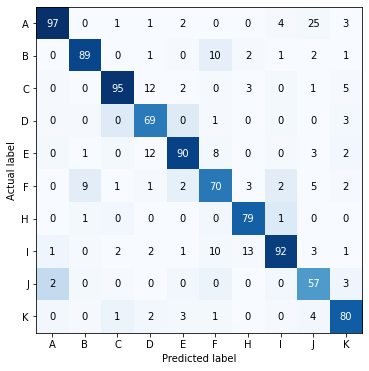

In [11]:
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import confusion_matrix, classification_report

test_datagen_predict = ImageDataGenerator()

# Note: make sure the test data is in alphanumeric order or the predict by setting .flow(shuffle = False)
# Then the predict_generator will base on the prediction value to match the label
test_generator_predict = test_datagen_predict.flow(testImages, testLabel, batch_size=batch_size, shuffle=False)
y_pred = model.predict_generator(test_generator_predict)
print(y_pred)
print(y_pred.shape)


cm = confusion_matrix(testLabel.argmax(axis=1), y_pred.argmax(axis=1))
cr = classification_report(testLabel.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)
print(cr)

## print confusion matrix 
plt.figure(figsize = (6, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
indices = range(len(cm))
class_name = ["A", "B", "C", "D", "E", "F", "H", "I", "J", "K"]
plt.xticks(indices, class_name)
plt.yticks(indices, class_name)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
for first_index in range(len(cm)):
  for second_index in range(len(cm[first_index])):
    if first_index == second_index:
      plt.text(first_index, second_index, cm[first_index][second_index], horizontalalignment='center', verticalalignment='center',color="white")
    else:
      plt.text(first_index, second_index, cm[first_index][second_index], horizontalalignment='center', verticalalignment='center',)
plt.show()